In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets

In [2]:
iris = datasets.load_iris()
features = iris.data
target = iris.target

sepal_length = np.array(features[:,0])
petal_width = np.array(features[:,3])

species_map = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
species_names = [species_map[i] for i in target]

In [3]:
def predict(intercept, coefficient, x):
  return intercept + coefficient * x

In [4]:
def sgd(x, y, df, epochs=100, alpha=0.01):
    intercept, coefficient = 0.0, 0.0
    random_index = np.random.randint(len(features))
    prediction = predict(intercept, coefficient, x[random_index])
    error = ((prediction - y[random_index]) ** 2) / 2

    df.loc[0] = [intercept, coefficient, error]

    for epoch in range(0, epochs):
        random_index = np.random.randint(len(features))
        prediction = predict(intercept, coefficient, x[random_index])
        b0_error = prediction - y[random_index]
        b1_error = (prediction - y[random_index]) * x[random_index]
        intercept = intercept - alpha * b0_error
        coefficient = coefficient - alpha * b1_error

        mean_squared_error = ((prediction - y[random_index]) ** 2) / 2
        df.loc[epoch] = [intercept, coefficient, mean_squared_error]

    return df

In [5]:
def sgd_momentum(x, y, df, epochs=100, alpha=0.01, gamma=0.9):
    intercept, coefficient = 0.0, 0.0
    b0_velocity, b1_velocity = 0.0, 0.0
    random_index = np.random.randint(len(features))
    prediction = predict(intercept, coefficient, x[random_index])
    error = ((prediction - y[random_index]) ** 2) / 2

    df.loc[0] = [intercept, coefficient, b0_velocity, b1_velocity, error]

    for epoch in range(1, epochs + 1):
        random_index = np.random.randint(len(features))
        prediction = predict(intercept, coefficient, x[random_index])
        b0_error = prediction - y[random_index]
        b1_error = (prediction - y[random_index]) * x[random_index]
        b0_velocity = gamma * b0_velocity + alpha * b0_error
        b1_velocity = gamma * b1_velocity + alpha * b1_error
        intercept = intercept - b0_velocity
        coefficient = coefficient - b1_velocity

        mean_squared_error = ((prediction - y[random_index]) ** 2) / 2
        df.loc[epoch] = [intercept, coefficient, b0_velocity, b1_velocity, mean_squared_error]

    return df

In [6]:
def sgd_nesterov(x, y, df, epochs=100, alpha=0.01, gamma=0.9):
    intercept, coefficient = 0.0, 0.0
    b0_velocity, b1_velocity = 0.0, 0.0

    random_index = np.random.randint(len(features))
    prediction = predict(intercept, coefficient, x[random_index])
    error = (prediction - y[random_index]) ** 2

    df.loc[0] = [intercept, coefficient, b0_velocity, b1_velocity, error]

    for epoch in range(1, epochs + 1):
        random_index = np.random.randint(len(features))

        lookahead_intercept = intercept - gamma * b0_velocity
        lookahead_coefficient = coefficient - gamma * b1_velocity

        lookahead_prediction = predict(lookahead_intercept, lookahead_coefficient, x[random_index])

        b0_error = lookahead_prediction - y[random_index]
        b1_error = (lookahead_prediction - y[random_index]) * x[random_index]

        b0_velocity = gamma * b0_velocity + alpha * b0_error
        b1_velocity = gamma * b1_velocity + alpha * b1_error

        intercept = intercept - b0_velocity
        coefficient = coefficient - b1_velocity

        prediction = predict(intercept, coefficient, x[random_index])
        mean_squared_error = ((prediction - y[random_index]) ** 2) / 2

        df.loc[epoch] = [intercept, coefficient, b0_velocity, b1_velocity, mean_squared_error]

    return df


In [7]:
sgd_columns = ['intercept', 'coefficient', 'sum_error']
sgd_loss_df = pd.DataFrame(columns=sgd_columns)
sgd_loss_df = sgd(sepal_length, petal_width, sgd_loss_df)

sgd_momentum_columns = ['intercept', 'coefficient', 'intercept_velocity', 'coefficient_velocity', 'sum_error']
sgd_momentum_loss_df = pd.DataFrame(columns=sgd_momentum_columns)
sgd_momentum_loss_df = sgd_momentum(sepal_length, petal_width, sgd_momentum_loss_df)

sgd_nesterov_columns = ['intercept', 'coefficient', 'intercept_velocity', 'coefficient_velocity', 'sum_error']
sgd_nesterov_loss_df = pd.DataFrame(columns=sgd_nesterov_columns)
sgd_nesterov_loss_df = sgd_nesterov(sepal_length, petal_width, sgd_nesterov_loss_df)

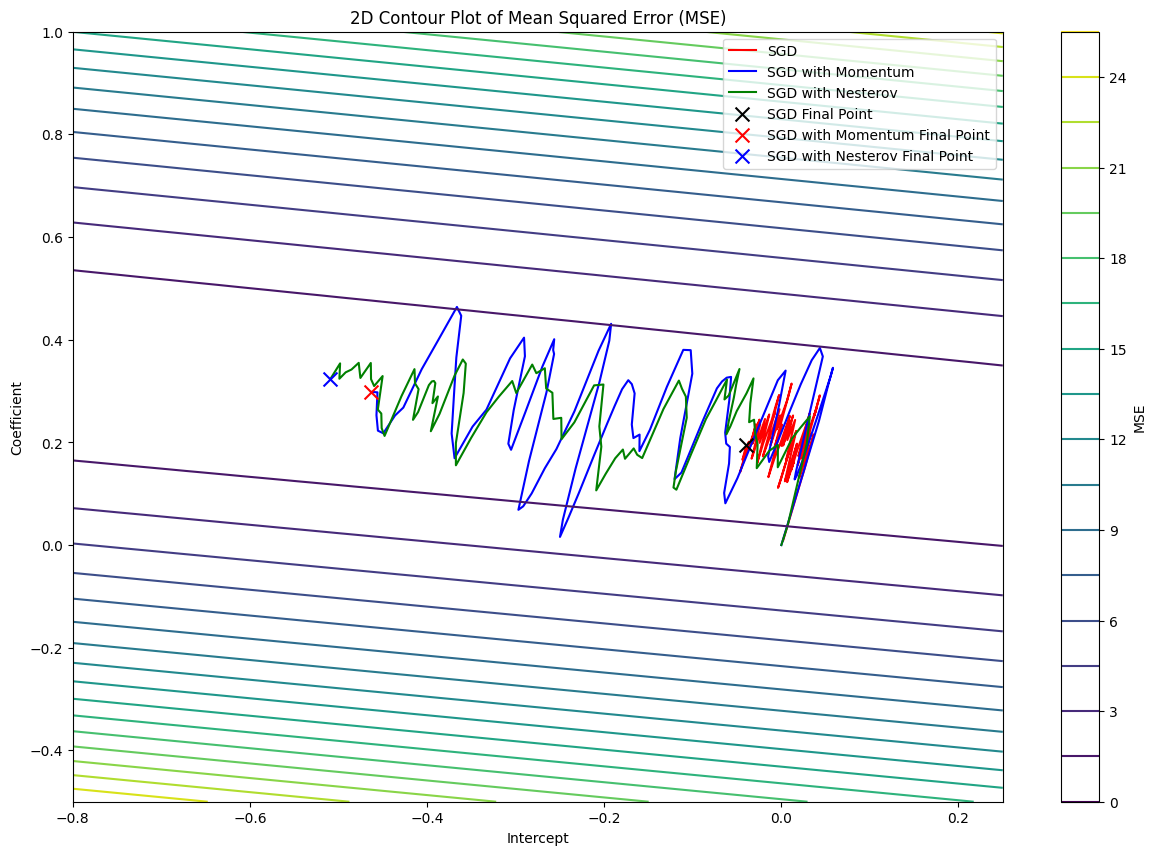

In [15]:
intercept_range = np.linspace(-0.8, 0.25, 150)
coefficient_range = np.linspace(-0.5, 1.0, 150)
intercept_grid, coefficient_grid = np.meshgrid(intercept_range, coefficient_range)

mse_grid = np.zeros_like(intercept_grid)

for i in range(len(intercept_range)):
    for j in range(len(coefficient_range)):
        # Get current intercept and coefficient values
        intercept = intercept_grid[i, j]
        coefficient = coefficient_grid[i, j]
        
        # Calculate predicted values using the current intercept and coefficient
        y_pred = intercept + coefficient * sepal_length.squeeze()
        
        # Calculate MSE (Mean Squared Error)
        mse = np.mean((y_pred - petal_width)**2)
        
        # Store MSE in the corresponding grid position
        mse_grid[i, j] = mse

plt.figure(figsize=(15, 10))
contour = plt.contour(intercept_grid, coefficient_grid, mse_grid, levels=20, cmap='viridis')
plt.colorbar(contour, label='MSE')
plt.plot(sgd_loss_df['intercept'], sgd_loss_df['coefficient'], color='red', zorder=1)
plt.plot(sgd_momentum_loss_df['intercept'], sgd_momentum_loss_df['coefficient'], color='blue', zorder=1)
plt.plot(sgd_nesterov_loss_df['intercept'], sgd_nesterov_loss_df['coefficient'], color='green', zorder=1)
plt.xlabel('Intercept')
plt.ylabel('Coefficient')
plt.title('2D Contour Plot of Mean Squared Error (MSE)')
plt.scatter(sgd_loss_df.loc[len(sgd_loss_df)-1, 'intercept'], sgd_loss_df.loc[len(sgd_loss_df)-1, 'coefficient'], color='black', marker='x', s=100, zorder=2)
plt.scatter(sgd_momentum_loss_df.loc[len(sgd_momentum_loss_df)-1, 'intercept'], sgd_momentum_loss_df.loc[len(sgd_momentum_loss_df)-1, 'coefficient'], color='red', marker='x', s=100, zorder=2)
plt.scatter(sgd_nesterov_loss_df.loc[len(sgd_nesterov_loss_df)-1, 'intercept'], sgd_nesterov_loss_df.loc[len(sgd_nesterov_loss_df)-1, 'coefficient'], color='blue', marker='x', s=100, zorder=2)
plt.legend(['SGD', 'SGD with Momentum', 'SGD with Nesterov', 'SGD Final Point', 'SGD with Momentum Final Point', 'SGD with Nesterov Final Point'])
plt.show()